In [10]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cvxpy as cp
from scipy.integrate import quad, dblquad
from scipy.special import erfc, erfinv, erfcinv
from scipy.optimize import root
sns.set(style='ticks',font_scale=1.2)

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

def solve_perceptron(X,y):
    N = X.shape[0]

    # Convex optimization
    w_var = cp.Variable(N)
    yhat = w_var@X
    loss = cp.sum(cp.pos(-cp.multiply(yhat,y)))
    prob = cp.Problem(
            cp.Minimize(cp.norm2(w_var)),
            [cp.multiply(y,yhat) >= 1]
    )
    prob.solve()
    w = w_var.value

    return w

def Theta(x):
    return (np.sign(x)+1)/2

def p(x):
    dist = np.exp(-x**2/2)/np.sqrt(2*np.pi)
    return dist*Theta(kthresh-np.abs(x))/f

# print(erfinv(0.1)*np.sqrt(2))

In [11]:
######## import
def intg_q(t,z,k,R,rho,R0,):
    A = 1-rho**2-R**2-R0**2+2*rho*R*R0
    tmeasure = np.exp(-(t-rho*z)**2/2/(1-rho**2))/np.sqrt(2*np.pi)/np.sqrt(1-rho**2)
    zmeasure = p(z)
    integrand = H(-(t*(R-rho*R0)-z*(rho*R-R0))/np.sqrt(1-rho**2)/np.sqrt(A))*(k-t)**2
    prefac = 2
    return tmeasure*zmeasure*integrand*prefac

def intg_R(t,z,k,R,rho,R0,):
    A = -(rho**2+R**2-2*rho*R*R0+R0**2-1)
    tmeasure = np.exp(-(z**2*(rho**2-2*rho*R*R0+R0**2)+2*t*z*(R*R0-rho)-(R0**2-1)*t**2)/2/A)
    zmeasure = p(z)
    prefac = 1/np.pi/np.sqrt(A)
    integrand = k-t

    return tmeasure*zmeasure*prefac*integrand


def intg_rho(t,z,k,R,rho,R0,):
    A = -(rho**2+R**2-2*rho*R*R0+R0**2-1)
    tmeasure = np.exp(-(t-rho*z)**2/2/(1-rho**2))/np.sqrt(2*np.pi)/np.sqrt(1-rho**2)
    zmeasure = p(z)
    integrand = H(-(t*(R-rho*R0)-z*(rho*R-R0))/np.sqrt(1-rho**2)/np.sqrt(A))*(z-rho*t)/(1-rho**2)*(k-t)
    prefac = 2
    term1 = tmeasure*zmeasure*prefac*integrand

    tmeasure = np.exp(-(z**2*(rho**2-2*rho*R*R0+R0**2)+2*t*z*(R*R0-rho)-(R0**2-1)*t**2)/2/A)
    zmeasure = p(z)
    prefac = -(R0-R*rho)/(1-rho**2)/np.pi/np.sqrt(A)
    integrand = k-t
    term2 = tmeasure*zmeasure*prefac*integrand

    return term1+term2


def eq_R(k,R,rho,R0,alpha):
    intg,tol = dblquad(intg_R,-kthresh,kthresh,-np.inf,k,args=(k,R,rho,R0))
    rhs = alpha*intg
    lhs = (R - rho*R0)/(1-R0**2)
    return rhs - lhs

def eq_q(k,R,rho,R0,alpha):
    intg,tol = dblquad(intg_q,-kthresh,kthresh,-np.inf,k,args=(k,R,rho,R0))
    rhs = alpha*intg
    lhs = 1-(rho**2+R**2-2*R0*R*rho)/(1-R0**2)
    return rhs - lhs

def eq_rho(k,R,rho,R0,alpha):
    intg,tol = dblquad(intg_rho,-kthresh,kthresh,-np.inf,k,args=(k,R,rho,R0))
    rhs = alpha*intg
    lhs = (rho-R*R0)/(1-R0**2)
    return rhs - lhs

def eq(args,R0,alpha):
    k,R,rho = args
    A = -(rho**2+R**2-2*rho*R*R0+R0**2-1)
    if R < 1-1e-8 and rho**2<1-1e-8 and k>1e-8 and A>1e-8:
        return eq_R(k,R,rho,R0,alpha), eq_q(k,R,rho,R0,alpha), eq_rho(k,R,rho,R0,alpha)
    else:
        return R**2+rho**2-1e3*k-1e3*A,R**2+rho**2-1e3*k-1e3*A,R**2+rho**2-1e3*k-1e3*A
    
def eq_root(args,alpha,kthresh):
    k,R = args
    if 1e-10<R<1-1e-10:
      return eq1(k,R,alpha,kthresh), eq2(k,R,alpha,kthresh)
    elif R<=1e-10:
      return -R**2,-R**2
    else:
      return R**2,R**2
    
def eq1(k,R,alpha,kthresh):
    intg,tol = quad(intg1,-np.inf,k,args=(k,R,kthresh))
    rhs = 2*alpha*intg/np.sqrt(1-R**2)
    lhs = R
    return rhs - lhs

def eq2(k,R,alpha,kthresh):
    intg,tol = quad(intg2,-np.inf,k,args=(k,R,kthresh))
    rhs = 2*alpha*intg
    lhs = 1-R**2
    return rhs - lhs

def intg1(t,k,R,kthresh):
    measure = np.exp(-t**2/(2*(1-R**2)))*(np.exp(kthresh*(2*R*t-kthresh)/(2*(1-R**2)))-1)/(2*np.pi)
    integrand = (t-k)/f
    return measure*integrand

def intg2(t,k,R,kthresh):
    measure = np.exp(-t**2/2)/np.sqrt(2*np.pi)*(1-H((kthresh-R*t)/np.sqrt(1-R**2))-H(R*t/np.sqrt(1-R**2)))
    integrand = (k-t)**2/f
    return measure*integrand

In [12]:
######### different theta
fs = np.logspace(-2,0,12)
# fs = np.linspace(0.1,1,12)
navg = 50

N = 30
Rs = []
Rstheory = []
thetas = np.array([0,10,20])*np.pi/180
sums = np.array([5,10,20,50,100])

for theta in thetas:
  R0 = np.cos(theta)
  for f in tqdm(fs):
    kthresh = erfinv(f)*np.sqrt(2)
    for sum in sums:
      alpha = sum*f
      Rtmp = []
      ktmp = []
      rhotmp = []
      for _ in range(navg):
        # P = int(alpha*N)
        # X = np.random.randn(N,P)/np.sqrt(N)
        # a = np.random.randn(int(1000000))/np.sqrt(N)
        # # X[0] = a[np.abs(a)<kthresh/np.sqrt(N)][:P]
        P = int( sum * f * N)
        a = np.random.randn(N,int(sum * N)) / np.sqrt(N)
        first_column_abs = np.abs(a[0,:])
        sorted_indices = np.argsort(first_column_abs)
        selected_columns = sorted_indices[:P]
        X = a[:, selected_columns]

        w_teacher = np.random.randn(N)
        w_teacher /= np.linalg.norm(w_teacher[1:])
        w_teacher *= np.sqrt(1-R0**2)
        w_teacher[0] = R0
        y = np.sign(w_teacher@X)
        w_student = solve_perceptron(X,y)
        R = np.corrcoef([w_student,w_teacher])[0,1]
        w_prune = np.zeros(N)
        w_prune[0] = 1
        rho = np.corrcoef([w_student,w_prune])[0,1]
        rhotmp.append(rho)
        k = np.sqrt(N)/np.linalg.norm(w_student)
        Rtmp.append(R)
        ktmp.append(k)
      Rs.append(np.mean(Rtmp))
        # R0 = R

      if theta!=0:
        out = root(eq,(np.mean(ktmp),np.mean(Rtmp),np.mean(rhotmp)),args=(R0,alpha))
      else:
        out = root(eq_root,(np.mean(ktmp),np.mean(Rtmp)),args=(alpha,kthresh))
      if out.success:
          Rtheory = out.x[1]
      else:
          Rtheory = np.nan
      Rstheory.append(Rtheory)
Rs_prune = np.stack(Rs).reshape(len(thetas),len(fs),len(sums))
Rstheory = np.stack(Rstheory).reshape(len(thetas),len(fs),len(sums))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

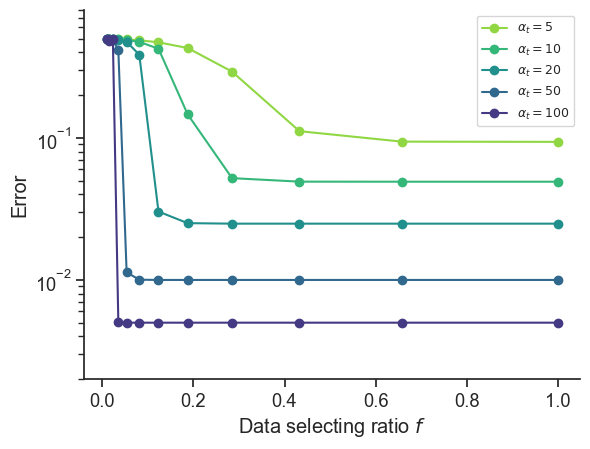

In [13]:
#np.save('Rstheory.npy', Rstheory)
# Rstheory = np.load('Rstheory.npy')

# plt.figure(figsize=(5, 4))
# fs = np.logspace(-2,0,14)
# sums = np.array([5,10,20,50,100])
with sns.color_palette('viridis_r', len(sums)):
    # plt.subplot(131)
    for i in range(len(sums)):
     #  plt.plot(fs, np.arccos(Rs_prune[0, :, i]) / np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
        plt.plot(fs, np.arccos(Rstheory[0,:,i])/np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    plt.yscale('log')
    plt.ylabel('Error')
    plt.xlabel('Data selecting ratio $f$')
    sns.despine()
    # plt.title(r'$\theta=0 \degree$')
    plt.ylim(2e-3, 8e-1)
    plt.legend(fontsize=9)  

    # plt.subplot(142)
    # for i in range(len(sums)):
    # #    plt.plot(fs, np.arccos(Rs_prune[1, :, i]) / np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    #     plt.plot(fs, np.arccos(Rstheory[1,:,i])/np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    # plt.yscale('log')
    # plt.ylabel('Error')
    # plt.xlabel('Data selecting ratio $f$')
    # sns.despine()
    # plt.title(r'$\theta=10 \degree$')
    # plt.ylim(2e-3, 8e-1)
    # plt.legend(fontsize=6)

    # plt.subplot(143)
    # for i in range(len(sums)):
    # #    plt.plot(fs, np.arccos(Rs_prune[2, :, i]) / np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    #     plt.plot(fs, np.arccos(Rstheory[2,:,i])/np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    # plt.yscale('log')
    # plt.ylabel('Error')
    # plt.xlabel('Data selecting ratio $f$')
    # sns.despine()
    # plt.title(r'$\theta=20 \degree$')
    # plt.ylim(2e-3, 8e-1)
    # plt.legend(fontsize=6)

    # plt.subplot(144)
    # for i in range(len(sums)):
    #  #   plt.plot(fs, np.arccos(Rs_prune[3, :, i]) / np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    #     plt.plot(fs, np.arccos(Rstheory[3,:,i])/np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    # plt.yscale('log')
    # plt.ylabel('Error')
    # plt.xlabel('Data selecting ratio $f$')
    # sns.despine()
    # plt.title(r'$\theta=30 \degree$')
    # plt.ylim(2e-3, 8e-1)
    # plt.legend(fontsize=6)

# plt.tight_layout()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
# plt.savefig('theta_0.pdf')
plt.show()



In [14]:
######## redundent
rong_yu = 10

fs = np.logspace(-2,0,12)
# fs = np.linspace(0.1,1,12)
navg = 50

N = 30
Rs = []
Rstheory = []
theta = np.array(10)*np.pi/180
sums = np.array([20,50,100,200,500])

R0 = np.cos(theta)
for f in tqdm(fs):
  kthresh = erfinv(f)*np.sqrt(2)
  for sum in sums:
    alpha = sum*f
    Rtmp = []
    ktmp = []
    rhotmp = []
    for _ in range(navg):
      # P = int(alpha*N)
      # X = np.random.randn(N,P)/np.sqrt(N)
      # a = np.random.randn(int(1000000))/np.sqrt(N)
      # # X[0] = a[np.abs(a)<kthresh/np.sqrt(N)][:P]
      P = int( sum * f * N)
      a = np.random.randn(N,int(sum * N/rong_yu)) / np.sqrt(N)
      a = np.tile(a,(1,rong_yu))
      first_column_abs = np.abs(a[0,:])
      sorted_indices = np.argsort(first_column_abs)
      selected_columns = sorted_indices[:P]
      X = a[:, selected_columns]

      w_teacher = np.random.randn(N)
      w_teacher /= np.linalg.norm(w_teacher[1:])
      w_teacher *= np.sqrt(1-R0**2)
      w_teacher[0] = R0
      y = np.sign(w_teacher@X)
      w_student = solve_perceptron(X,y)
      R = np.corrcoef([w_student,w_teacher])[0,1]
      w_prune = np.zeros(N)
      w_prune[0] = 1
      rho = np.corrcoef([w_student,w_prune])[0,1]
      rhotmp.append(rho)
      k = np.sqrt(N)/np.linalg.norm(w_student)
      Rtmp.append(R)
      ktmp.append(k)
    Rs.append(np.mean(Rtmp))
      # R0 = R

    if theta!=0:
      out = root(eq,(np.mean(ktmp),np.mean(Rtmp),np.mean(rhotmp)),args=(R0,alpha))
    else:
      out = root(eq_root,(np.mean(ktmp),np.mean(Rtmp)),args=(alpha,kthresh))
    if out.success:
        Rtheory = out.x[1]
    else:
        Rtheory = np.nan
    Rstheory.append(Rtheory)
Rs_prune = np.stack(Rs).reshape(1,len(fs),len(sums))
Rstheory = np.stack(Rstheory).reshape(1,len(fs),len(sums))

  0%|          | 0/12 [00:00<?, ?it/s]

d:\anaconda\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\anaconda\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


C:\Windows\Temp\ipykernel_65296\85848498.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=sums, orientation='vertical', pad=0.05)


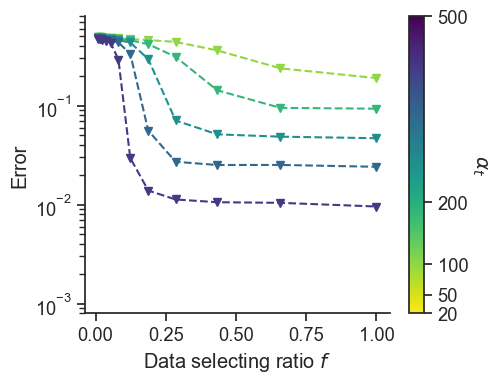

In [15]:
plt.figure(figsize=(5, 4))

with sns.color_palette('viridis_r', len(sums)):

    for i in range(len(sums)):
         plt.plot(fs, np.arccos(Rs_prune[0, :, i]) / np.pi, '--v', label=r'$\alpha_t={}$'.format(sums[i]))
       # plt.plot(fs, np.arccos(Rstheory[0,:,i])/np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    plt.yscale('log')
    plt.ylabel('Error')
    plt.xlabel('Data selecting ratio $f$')
    sns.despine()
    # plt.title(r'$\theta=10 \degree$')
    plt.ylim(8e-4, 8e-1)
    # plt.legend(fontsize=9)  

plt.tight_layout()
# plt.grid(linestyle='--', which='both')
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=min(sums), vmax=max(sums)))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=sums, orientation='vertical', pad=0.05)
cbar.set_label(r'$\alpha_t$', rotation=270, labelpad=15)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)

# plt.savefig('copy_10.eps')
# plt.show()



In [16]:
############# downstream bias
fs = np.logspace(-2,0,12)
# fs = np.linspace(0.1,1,12)
navg = 50

N = 30
Rs = []
Rstheory = []
theta = np.array(10)*np.pi/180
sums = np.array([20,50,100,200,500])

R0 = np.cos(theta)
for f in tqdm(fs):
  kthresh = erfinv(f)*np.sqrt(2)
  for sum in sums:
    alpha = sum*f
    Rtmp = []
    ktmp = []
    rhotmp = []
    for _ in range(navg):

      P = int( sum * f * N)
      a = np.random.randn(N,int(sum * N)) / np.sqrt(N)
      first_column_abs = np.abs(a[0,:])
      sorted_indices = np.argsort(first_column_abs)
      selected_columns = sorted_indices[:P]
      X = a[:, selected_columns]

      w_teacher = np.random.randn(N)
      w_teacher /= np.linalg.norm(w_teacher[1:])
      w_teacher *= np.sqrt(1-R0**2)
      w_teacher[0] = R0

      y = np.sign(w_teacher@X)

      w_down = np.zeros(N)
      w_down[0] = 1
      epsilon = 0.4  
      random_noise = epsilon * np.ones(N)
      random_noise[0] = 0
      w_down = w_teacher + random_noise
      norm = np.linalg.norm(w_down)
      w_down = w_down / norm

      w_student = solve_perceptron(X,y)
      R = np.corrcoef([w_student,w_down])[0,1]
      w_prune = np.zeros(N)
      w_prune[0] = 1
      rho = np.corrcoef([w_student,w_prune])[0,1]
      rhotmp.append(rho)
      k = np.sqrt(N)/np.linalg.norm(w_student)
      Rtmp.append(R)
      ktmp.append(k)
    Rs.append(np.mean(Rtmp))
      # R0 = R

    if theta!=0:
      out = root(eq,(np.mean(ktmp),np.mean(Rtmp),np.mean(rhotmp)),args=(R0,alpha))
    else:
      out = root(eq_root,(np.mean(ktmp),np.mean(Rtmp)),args=(alpha,kthresh))
    if out.success:
        Rtheory = out.x[1]
    else:
        Rtheory = np.nan
    Rstheory.append(Rtheory)
Rs_prune = np.stack(Rs).reshape(1,len(fs),len(sums))
Rstheory = np.stack(Rstheory).reshape(1,len(fs),len(sums))




  0%|          | 0/12 [00:00<?, ?it/s]

C:\Windows\Temp\ipykernel_65296\2734793594.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=sums, orientation='vertical', pad=0.05)


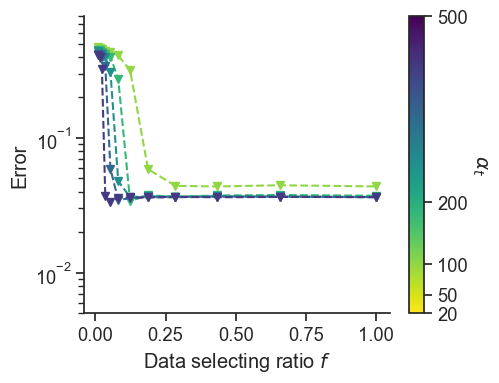

In [17]:
plt.figure(figsize=(5, 4))

with sns.color_palette('viridis_r', len(sums)):

    for i in range(len(sums)):
         plt.plot(fs, np.arccos(Rs_prune[0, :, i]) / np.pi, '--v', label=r'$\alpha_t={}$'.format(sums[i]))
       # plt.plot(fs, np.arccos(Rstheory[0,:,i])/np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
    plt.yscale('log')
    plt.ylabel('Error')
    plt.xlabel('Data selecting ratio $f$')
    sns.despine()
    # plt.title(r'$\theta=10 \degree$')
    plt.ylim(5e-3, 8e-1)
    # plt.legend(fontsize=9)  

plt.tight_layout()
# plt.grid(linestyle='--', which='both')
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=min(sums), vmax=max(sums)))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=sums, orientation='vertical', pad=0.05)
cbar.set_label(r'$\alpha_t$', rotation=270, labelpad=15)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)

# plt.savefig('error_0.4.eps')
plt.show()



In [18]:
############# difficulty
fs = np.logspace(-2,0,12)
# fs = np.linspace(0.1,1,12)
navg = 50

N = 30
Rs = []
Rs2 = []
Rs3 = []
Rstheory = []
theta = np.array(10)*np.pi/180
sums = np.array([20,50,100,200,500])

R0 = np.cos(theta)
for f in tqdm(fs):
  kthresh = erfinv(f)*np.sqrt(2)
  for sum in sums:
    alpha = sum*f
    Rtmp = []
    Rtmp_2 = []
    Rtmp_3 = []
    ktmp = []
    rhotmp = []
    for _ in range(navg):
      w_teacher = np.random.randn(N)
      w_teacher /= np.linalg.norm(w_teacher[1:])
      w_teacher *= np.sqrt(1-R0**2)
      w_teacher[0] = R0
      P = int( sum * f * N)
      a = np.random.randn(N,int(sum * N)) / np.sqrt(N)
      first_column_abs = np.abs(a[0,:])

      sorted_indices = np.argsort(first_column_abs)
      selected_columns = sorted_indices[:P]
      X = a[:, selected_columns]

      sorted_indices_2 = np.argsort(first_column_abs)[::-1]  # 
      selected_columns_2 = sorted_indices_2[:P]
      X_2 = a[:, selected_columns_2]

      sorted_indices_3 = np.argsort(first_column_abs)
      np.random.shuffle(sorted_indices_3)  
      selected_columns_3 = sorted_indices_3[:P]
      X_3 = a[:, selected_columns_3]

      y = np.sign(w_teacher@X)
      y_2 = np.sign(w_teacher@X_2)
      y_3 = np.sign(w_teacher@X_3)

      w_student = solve_perceptron(X,y)
      w_student_2 = solve_perceptron(X_2,y_2)
      w_student_3 = solve_perceptron(X_3,y_3)

      R = np.corrcoef([w_student,w_teacher])[0,1]
      R_2 = np.corrcoef([w_student_2,w_teacher])[0,1]
      R_3 = np.corrcoef([w_student_3,w_teacher])[0,1]

    #   w_prune = np.zeros(N)
    #   w_prune[0] = 1
    #   rho = np.corrcoef([w_student,w_prune])[0,1]
    #   rhotmp.append(rho)
    #   k = np.sqrt(N)/np.linalg.norm(w_student)
      Rtmp.append(R)
      Rtmp_2.append(R_2)
      Rtmp_3.append(R_3)
    #   ktmp.append(k)
    Rs.append(np.mean(Rtmp))
    Rs2.append(np.mean(Rtmp_2))
    Rs3.append(np.mean(Rtmp_3))
      # R0 = R

    # if theta!=0:
    #   out = root(eq,(np.mean(ktmp),np.mean(Rtmp),np.mean(rhotmp)),args=(R0,alpha))
    # else:
    #   out = root(eq_root,(np.mean(ktmp),np.mean(Rtmp)),args=(alpha,kthresh))
    # if out.success:
    #     Rtheory = out.x[1]
    # else:
    #     Rtheory = np.nan
    # Rstheory.append(Rtheory)
Rs_prune = np.stack(Rs).reshape(1,len(fs),len(sums))
Rs_prune_2 = np.stack(Rs2).reshape(1,len(fs),len(sums))
Rs_prune_3 = np.stack(Rs3).reshape(1,len(fs),len(sums))
# Rstheory = np.stack(Rstheory).reshape(1,len(fs),len(sums))




  0%|          | 0/12 [00:00<?, ?it/s]

C:\Windows\Temp\ipykernel_65296\61064957.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=sums, orientation='vertical', pad=0.05)


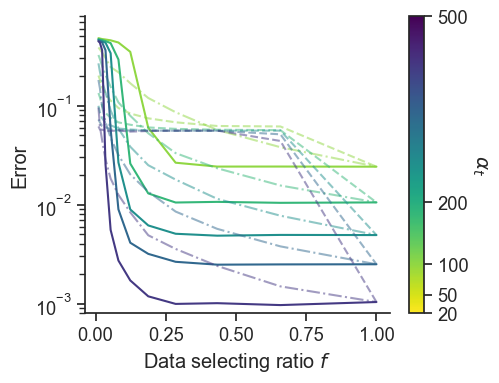

In [19]:
# np.save('Rs_hard.npy', Rs_prune)
# np.save('Rs_easy.npy', Rs_prune_2)
# np.save('Rs_random.npy', Rs_prune_3)

plt.figure(figsize=(5, 4))

colors = sns.color_palette('viridis_r', len(sums))

# with sns.color_palette('viridis_r', len(sums)):
for i in range(len(sums)):
      plt.plot(fs, np.arccos(Rs_prune[0, :, i]) / np.pi, '-', color =  colors[i],alpha=1, label=r'$\alpha_t={}$'.format(sums[i]))
      plt.plot(fs, np.arccos(Rs_prune_2[0, :, i]) / np.pi, '--', color = colors[i], alpha=0.5,label=r'$\alpha_t={}$'.format(sums[i]))
      plt.plot(fs, np.arccos(Rs_prune_3[0, :, i]) / np.pi, '-.', color = colors[i],alpha=0.5, label=r'$\alpha_t={}$'.format(sums[i]))
       # plt.plot(fs, np.arccos(Rstheory[0,:,i])/np.pi, 'o-', label=r'$\alpha_t={}$'.format(sums[i]))
plt.yscale('log')
plt.ylabel('Error')
plt.xlabel('Data selecting ratio $f$')
sns.despine()
# plt.title(r'$\theta=10 \degree$')
plt.ylim(8e-4, 8e-1)
    # plt.legend(fontsize=9)  # 

# 
plt.tight_layout()
# plt.grid(linestyle='--', which='both')
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=min(sums), vmax=max(sums)))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=sums, orientation='vertical', pad=0.05)
cbar.set_label(r'$\alpha_t$', rotation=270, labelpad=15)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
# plt.savefig('hard.pdf')
plt.show()



C:\Windows\Temp\ipykernel_65296\997657732.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=sums, orientation='vertical', pad=0.05)


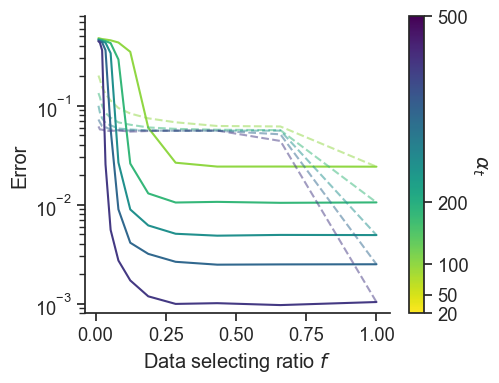

In [20]:
# Rs_prune = np.load('Rs_hard.npy')
# Rs_prune_2 = np.load('Rs_easy.npy')
# Rs_prune_3 = np.load('Rs_random.npy')
plt.figure(figsize=(5, 4))
fs = np.logspace(-2,0,12)
sums = np.array([20,50,100,200,500])
colors = sns.color_palette('viridis_r', len(sums))
for i in range(len(sums)):
      plt.plot(fs, np.arccos(Rs_prune[0, :, i]) / np.pi, '-', color =  colors[i],alpha=1, label=r'$\alpha_t={}$'.format(sums[i]))
      plt.plot(fs, np.arccos(Rs_prune_2[0, :, i]) / np.pi, '--', color = colors[i], alpha=0.5,label=r'$\alpha_t={}$'.format(sums[i]))
plt.yscale('log')
plt.ylabel('Error')
plt.xlabel('Data selecting ratio $f$')
sns.despine()
# plt.title(r'$\theta=10 \degree$')
plt.ylim(8e-4, 8e-1)
plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=min(sums), vmax=max(sums)))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=sums, orientation='vertical', pad=0.05)
cbar.set_label(r'$\alpha_t$', rotation=270, labelpad=15)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
# plt.savefig('hard.pdf')
plt.show()